In [66]:
# importando as bibliotecas 

import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])

# estados da união 
estados = {"AC": "Acre","AL": "Alagoas","AP": "Amapá","AM": "Amazonas","BA": "Bahia","CE": "Ceará","DF": "Distrito Federal","ES": "Espírito Santo","GO": "Goiás","MA": "Maranhão","MT": "Mato Grosso","MS": "Mato Grosso do Sul","MG": "Minas Gerais","PA": "Pará","PB": "Paraíba","PR": "Paraná","PE": "Pernambuco","PI": "Piauí","RJ": "Rio de Janeiro","RN": "Rio Grande do Norte","RS": "Rio Grande do Sul","RO": "Rondônia","RR": "Roraima","SC": "Santa Catarina","SP": "São Paulo","SE": "Sergipe","TO": "Tocantins"}

# regiões
siglas_para_regioes = {
    'SE':'Sudeste',
    'S' :'Sul',
    'N' : 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro\noeste'
}

# retirando colunas que não serão utilizadas do DataSet

gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])

# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)

# trocando o nome de siglas para o nome dos estados 
gas_eta['Estado - Sigla']=gas_eta['Estado - Sigla'].apply(lambda x:estados[x])

# trocando o nome das siglas das regiões para o nome das regiões
gas_eta['Regiao - Sigla']=gas_eta['Regiao - Sigla'].apply(lambda x:siglas_para_regioes[x])

# manipulando o nome dos municipios
gas_eta['Municipio']=gas_eta['Municipio'].apply(lambda x:x.replace(' ','\n'))

# trocando o nome das colunas em quê o valor foi alterado
gas_eta.rename(columns={'Estado - Sigla':'Estado','Regiao - Sigla':'Regiao'},inplace=True)


# criando o dataframe com o dado mdc=media diaria dos preços combustiveis 

# nesse dataframe tranformamos os valores da coluna produtos em colunas é as data em indices
# além disso acrescentamos as datas em que não foram feitas coletas utilizando o metodo nearest
# para que fosse atribuido a essas linhas o valor de indice mais proximo 
mdc=gas_eta.pivot_table(columns='Produto',index='Data da Coleta',values='Valor de Venda', aggfunc='mean').reindex(pd.date_range(start='2023-05-01',end='2023-06-30'),method='nearest')

# media no valor do combustivel nos ultimos dois meses 

media_combustivel=mdc.mean()

# media do valor por estado 

media_por_estado=gas_eta.pivot_table(columns='Produto',index='Estado',values='Valor de Venda', aggfunc='mean')

# dicionario com os estados com maior valor de combustiveis por estado

dic_combustives_estado={'GASOLINA_ADITIVADA':media_por_estado['GASOLINA ADITIVADA'].sort_values(ascending=False)[:5],
'GASOLINA':media_por_estado['GASOLINA'].sort_values(ascending=False)[:5],
'ETANOL':media_por_estado['ETANOL'].sort_values(ascending=False)[:5]
}
#media municipal
media_municipal=gas_eta.pivot_table(columns='Produto',index='Municipio',values='Valor de Venda', aggfunc='mean')

# dicionarios com os municipios com maior valor de combustivel 
 
municipios_mais_caros={'GASOLINA':media_municipal['GASOLINA'].sort_values(ascending=False)[:5],
'GASOLINA ADITIVADA':media_municipal['GASOLINA ADITIVADA'].sort_values(ascending=False)[:5],
'ETANOL':media_municipal['ETANOL'].sort_values(ascending=False)[:5]}

# dicionario com os municipios  mais baratos 

municipios_mais_baratos={'GASOLINA':media_municipal['GASOLINA'].sort_values()[:5],
'GASOLINA ADITIVADA':media_municipal['GASOLINA ADITIVADA'].sort_values()[:5],
'ETANOL':media_municipal['ETANOL'].sort_values()[:5]}

# media no valor dos combustiveis

preco_por_regiao=gas_eta.pivot_table(columns='Regiao',index='Produto',values='Valor de Venda', aggfunc='mean')

# media por data e produto, dividido por região 

media_regiao_data=gas_eta.pivot_table(columns='Regiao',values='Valor de Venda',index=['Produto','Data da Coleta'],aggfunc='mean').dropna()



In [76]:

media_regiao_data.loc['ETANOL'].corr()

Regiao,Centro\noeste,Nordeste,Norte,Sudeste,Sul
Regiao,,,,,
Centro\noeste,1.000000,0.060773,0.288691,0.904530,0.529457
Nordeste,0.060773,1.000000,0.016252,0.185818,-0.214911
Norte,0.288691,0.016252,1.000000,0.333680,0.012605
Sudeste,0.904530,0.185818,0.333680,1.000000,0.547824
Sul,0.529457,-0.214911,0.012605,0.547824,1.000000


In [132]:
def correlacao_combustivel():    
    fig=plt.figure(figsize=(18,6))
    g1=plt.subplot(131)
    g2=plt.subplot(132)
    g3=plt.subplot(133)


    etanol= sns.heatmap(media_regiao_data.loc['ETANOL'].corr(), annot=True, cmap=LinearSegmentedColormap.from_list('CustomColors',['white','Blue']), center=0, linewidths=.5, cbar=False,ax=g3)
    etanol.set_title('Etanol \n', color='Blue', fontweight='bold', fontsize=15, fontstyle='italic', loc='left')

    gasolina = sns.heatmap(media_regiao_data.loc['GASOLINA'].corr(), annot=True, cmap=LinearSegmentedColormap.from_list('CustomColors',['white','#a51b0b']), center=0, linewidths=.5, cbar=False,ax=g2)
    gasolina.set_title('Gasolina \n', color='#a51b0b', fontweight='bold', fontsize=15, fontstyle='italic', loc='left')

    gasolina_aditivada = sns.heatmap(media_regiao_data.loc['GASOLINA ADITIVADA'].corr(), annot=True, cmap=LinearSegmentedColormap.from_list('CustomColors',['white','#d11507']), center=0, linewidths=.5, cbar=False,ax=g1)
    gasolina_aditivada.set_title('Gasolina Aditivada \n', color='#d11507', fontweight='bold', fontsize=15, fontstyle='italic', loc='left')
    # Reduzir nomes exibidos no eixo x e y
    g1.set_xticklabels(g1.get_xticklabels(), rotation=0,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')  # Rótulos do eixo X rotacionados em 45 graus
    g1.set_yticklabels(g1.get_yticklabels(), rotation=45,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')
    g1.set_ylabel('') 
    g1.set_xlabel('') 

    g2.set_xticklabels(g2.get_xticklabels(), rotation=0,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')  # Rótulos do eixo X rotacionados em 45 graus
    g2.set_yticklabels(g2.get_yticklabels(), rotation=45,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')
    g2.set_ylabel('') 
    g2.set_xlabel('') 

    g3.set_xticklabels(g3.get_xticklabels(), rotation=0,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')  # Rótulos do eixo X rotacionados em 45 graus
    g3.set_yticklabels(g3.get_yticklabels(), rotation=45,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')
    g3.set_ylabel('') 
    g3.set_xlabel('') 


    # Configurar rótulos do cbar
    # cor_grafico = LinearSegmentedColormap.from_list('CustomColors', [corX,corY], N=27)# cor do gráfico de barras
    fig.suptitle('Correlação entre os valores dos combustiveis Brasil', fontsize=30, fontweight='bold', color='darkred',fontstyle= 'italic', x=0.05, ha='left')
    plt.tight_layout(rect=[0, 0.10, 1, 0.9])
    plt.subplots_adjust(wspace=0.4) 
    plt.show()

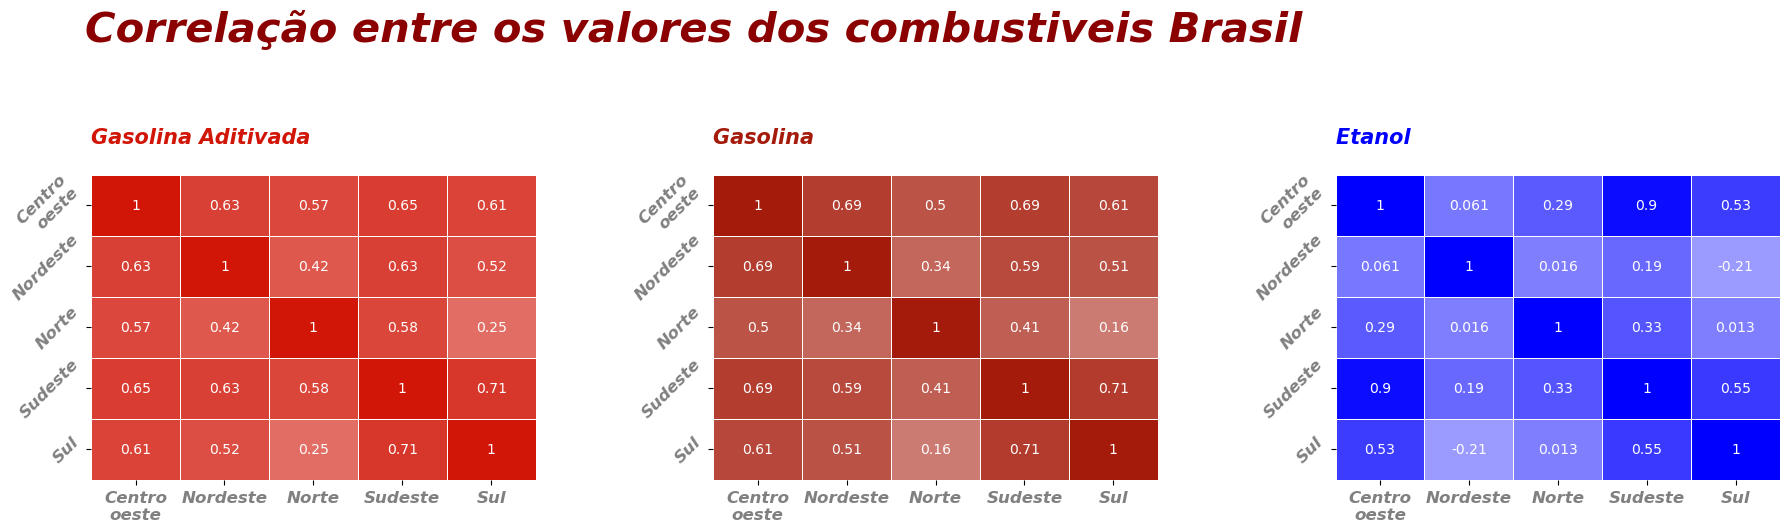

In [133]:
correlacao_combustivel()

In [ ]:
ax.set_xticks([1, 2, 3, 4, 5])  # Rótulos do eixo X em posições específicas
ax.set_xticklabels(["A", "B", "C", "D", "E"])  # Rótulos personalizados do eixo X

ax.set_yticks([0, 10, 20, 30, 40])  # Rótulos do eixo Y em posições específicas
ax.set_yticklabels(["Baixo", "Médio", "Alto", "Muito Alto", "Extremo"])  # Rótulos personalizados do eixo Y

g1.set_xticklabels(g1.get_xticklabels(), rotation=45,color='grey')  # Rótulos do eixo X rotacionados em 45 graus
g1.set_yticklabels(g1.get_yticklabels(), rotation=90,color='grey')  # Rótulos do eixo Y rotacionados em 90 graus


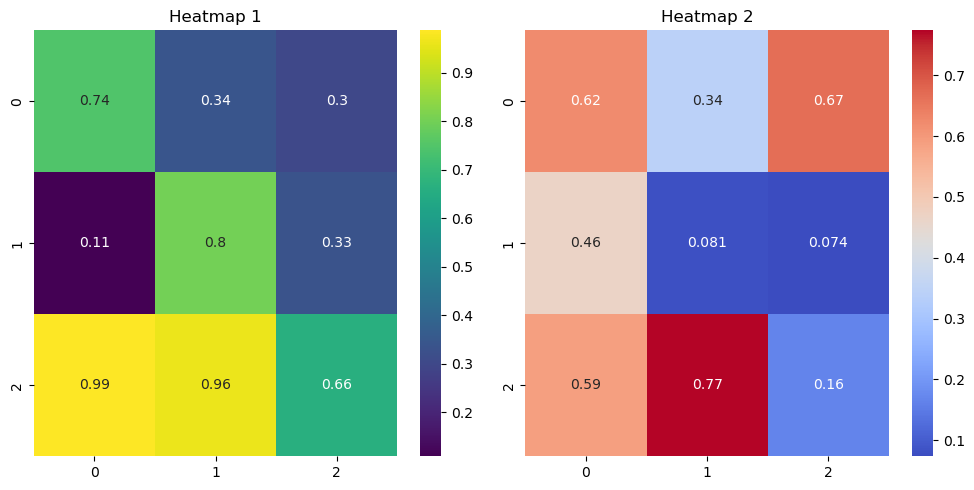

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dados de exemplo
data1 = np.random.rand(3, 3)
data2 = np.random.rand(3, 3)

# Criação da grade de subtramas (1 linha, 2 colunas)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Heatmap na primeira subtrama
sns.heatmap(data1, annot=True, cmap='viridis', ax=axs[0])
axs[0].set_title("Heatmap 1")

# Heatmap na segunda subtrama
sns.heatmap(data2, annot=True, cmap='coolwarm', ax=axs[1])
axs[1].set_title("Heatmap 2")

plt.tight_layout()
plt.show()
